<a href="https://colab.research.google.com/github/yeojunh/CPSC440-project/blob/main/cpsc440_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Noise in the Network: Comparing Defense Methods for Adversarial Examples in Neural Networks**

# Goals and Purpose of this notebook
Final project for CPSC 440.

In [ ]:
# cleverhans is not built into Google Colab
%pip install cleverhans --q

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import pickle

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights

import cleverhans
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack

# check we're using CUDA
print(torch.cuda.is_available(), torch.cuda.device_count())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.0 MB/s eta 0:00:00
True 1


# CIFAR-10 Dataset


In [ ]:
# Adapted from https://github.com/JayPatwardhan/ResNet-PyTorch

resnet_model_exists = True

fgsm_exists = False
cw_exists = True
alex_sl1d_exists = False

alex_fgsm_exists = True
alex_sl1d_exists = True

adversarial_training_model_exists = True
ensemble_training_model_exists = False

data_dir = 'data/cifar10'
batch_size = 128
num_workers = 2
epochs = 64
pin_memory = torch.cuda.is_available() # True if using CUDA

# transform functions
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# get CIFAR-10 data and dataloaders
train = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
train, validation = torch.utils.data.random_split(train, [0.7, 0.3])
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
validloader = DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
testloader = DataLoader(test, batch_size=batch_size,shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:


# Adapted from https://github.com/a-martyn/resnet/blob/master/data_loader.py/

# CIFAR10 labels
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Plot images with labels.
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """

    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[int(cls_true[i].item())]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


def plot_tensor(images, labels):
    X = images.detach().numpy().transpose([0, 2, 3, 1])
    plot_images(X, labels)


def plot_tensor_gpu(images, labels):
    X = images.cpu().detach().numpy().transpose([0, 2, 3, 1])
    y = labels.cpu().detach()
    plot_images(X, y)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


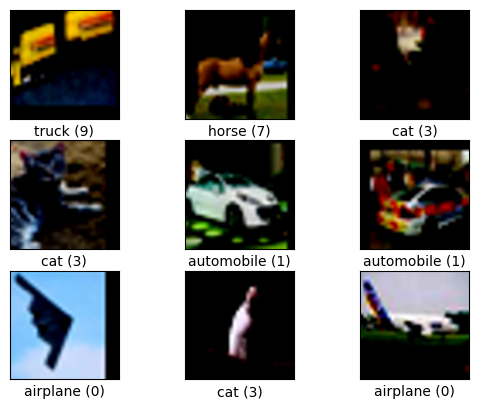

torch.Size([128, 3, 32, 32])

In [ ]:
img, label = next(iter(trainloader))
plot_tensor(img, label)
img.size()

# Control model: ResNet training
ResNet 50 implementation adapted from https://github.com/JayPatwardhan/ResNet-PyTorch/

In [ ]:
# ResNet helpers
# Adapted from https://github.com/JayPatwardhan/ResNet-PyTorch/

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x


class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)


def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)


def score(target_model, loader):
  correct = 0
  total = 0

  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to('cuda'), labels.to('cuda')
          outputs = target_model(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy on 10,000 images: ', 100*(correct/total), '%')


In [ ]:
# ResNet50 training
# Adapted from https://github.com/JayPatwardhan/ResNet-PyTorch/

from torchvision.models import resnet50, ResNet50_Weights


if (resnet_model_exists):
  resnet = pickle.load(open('resnet-model.pk1' , 'rb'))
  # resnet = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
else:
  resnet = ResNet50(10).to('cuda')
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

  for epoch in range(epochs):
      losses = []
      running_loss = 0
      for i, inp in enumerate(trainloader):
          inputs, labels = inp
          inputs, labels = inputs.to('cuda'), labels.to('cuda')
          optimizer.zero_grad()

          outputs = resnet(inputs)
          loss = criterion(outputs, labels)
          losses.append(loss.item())

          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          if i % 100 == 0 and i != 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

      avg_loss = sum(losses)/len(losses)
      scheduler.step(avg_loss)
  pickle.dump(resnet, open('resnet-model.pk1' , 'wb'))


# Adversarial example training
1. Fast Gradient Sign Method (FGSM)
2. Projected Gradient Descent (PGD)
3. Carlini-Wagner Attack
4. Sparse L1 Descent
5. Hop Skip Jump Attack


## Fast Gradient Sign Method (FGSM)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


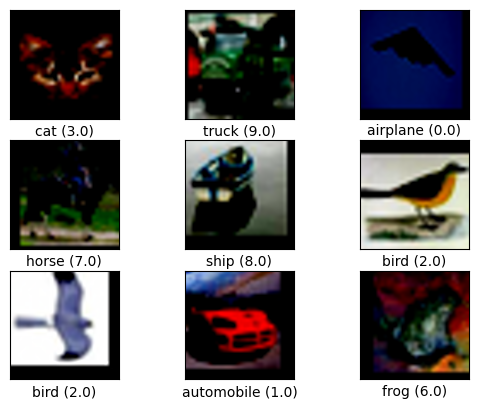

In [ ]:
# Adapted from https://github.com/cleverhans-lab/cleverhans/blob/master/tutorials/torch/cifar10_tutorial.py

epsilon = [0.001, 0.01, 0.07, 0.3]

if (fgsm_exists):
    # load datasets
    X_fgsm = pickle.load(open('X_fgsm.pk1' , 'rb'))
    y_fgsm = pickle.load(open('y_fgsm.pk1' , 'rb'))
    Xtest_fgsm = pickle.load(open('Xtest_fgsm.pk1' , 'rb'))
    ytest_fgsm = pickle.load(open('ytest_fgsm.pk1' , 'rb'))
else:
    X_fgsm = torch.Tensor()
    y_fgsm = torch.Tensor()
    Xtest_fgsm = torch.Tensor()
    ytest_fgsm = torch.Tensor()

    for e in epsilon:
        # train set
        train_images, train_labels = next(iter(trainloader))
        train_images = train_images.to('cuda')
        x_fgsm = fast_gradient_method(resnet, train_images, e, np.inf, targeted=False)

        X_fgsm = torch.cat((X_fgsm, x_fgsm.cpu()), 0)
        y_fgsm = torch.cat((y_fgsm, train_labels), 0)

        # test set
        test_images, test_labels = next(iter(testloader))
        test_images = test_images.to('cuda')
        xtest_fgsm = fast_gradient_method(resnet, test_images, e, np.inf, targeted=False)

        Xtest_fgsm = torch.cat((Xtest_fgsm, xtest_fgsm.cpu()), 0)
        ytest_fgsm = torch.cat((ytest_fgsm, test_labels), 0)

    # save datasets
    pickle.dump(X_fgsm, open('X_fgsm.pk1' , 'wb'))
    pickle.dump(y_fgsm, open('y_fgsm.pk1' , 'wb'))
    pickle.dump(Xtest_fgsm, open('Xtest_fgsm.pk1' , 'wb'))
    pickle.dump(ytest_fgsm, open('ytest_fgsm.pk1' , 'wb'))

plot_tensor_gpu(X_fgsm.detach(), y_fgsm.detach())

# create a trainloader with adversarial examples
fgsm_train = TensorDataset(X_fgsm, y_fgsm)
fgsm_test = TensorDataset(Xtest_fgsm, ytest_fgsm)

fgsm_trainloader = DataLoader(fgsm_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
fgsm_testloader = DataLoader(fgsm_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## The Carlini-Wagner Attack
Adapted from

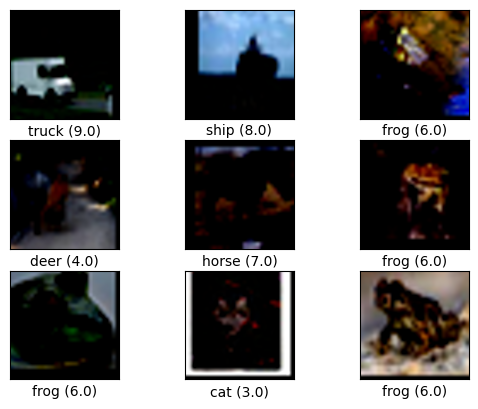

In [ ]:
# Adapted from https://github.com/cleverhans-lab/cleverhans/blob/master/tutorials/torch/cifar10_tutorial.py

if (cw_exists):
    # load datasets
    X_cw = pickle.load(open('X_cw.pk1' , 'rb'))
    y_cw = pickle.load(open('y_cw.pk1' , 'rb'))
    Xtest_cw = pickle.load(open('Xtest_cw.pk1' , 'rb'))
    ytest_cw = pickle.load(open('ytest_cw.pk1' , 'rb'))
else:
    X_cw = torch.Tensor()
    y_cw = torch.Tensor()
    Xtest_cw = torch.Tensor()
    ytest_cw = torch.Tensor()

    for e in epsilon:
        # train set
        train_images, train_labels = next(iter(trainloader))
        train_images, train_labels = train_images.to('cuda'), train_labels.to('cuda')
        x_cw = carlini_wagner_l2(resnet, train_images, 10, train_labels)

        X_cw = torch.cat((X_cw, x_cw.cpu()), 0)
        y_cw = torch.cat((y_cw, train_labels.cpu()), 0)

        # test set
        test_images, test_labels = next(iter(testloader))
        test_images, test_labels = test_images.to('cuda'), test_labels.to('cuda')
        xtest_cw = carlini_wagner_l2(resnet, test_images, 10, test_labels)

        Xtest_cw = torch.cat((Xtest_cw, xtest_cw.cpu()), 0)
        ytest_cw = torch.cat((ytest_cw, test_labels.cpu()), 0)

    # save datasets
    pickle.dump(X_cw, open('X_cw.pk1' , 'wb'))
    pickle.dump(y_cw, open('y_cw.pk1' , 'wb'))
    pickle.dump(Xtest_cw, open('Xtest_cw.pk1' , 'wb'))
    pickle.dump(ytest_cw, open('ytest_cw.pk1' , 'wb'))

plot_tensor_gpu(X_cw.detach(), y_cw.detach())

# create a trainloader with adversarial examples
cw_train = TensorDataset(X_cw, y_cw)
cw_test = TensorDataset(Xtest_cw, ytest_cw)

cw_trainloader = DataLoader(cw_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
cw_testloader = DataLoader(cw_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## The Sparse L1 Descent
Adapted from

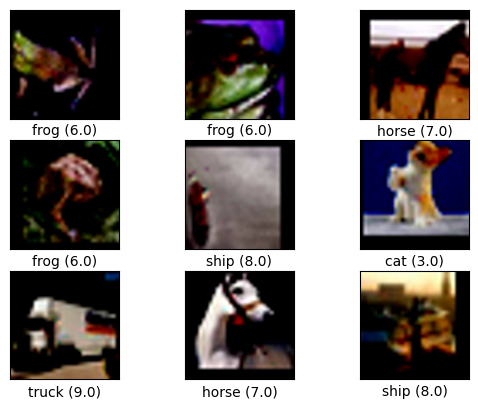

In [ ]:
# Adapted from https://github.com/cleverhans-lab/cleverhans/blob/master/tutorials/torch/cifar10_tutorial.py

if (sl1d_exists):
    # load datasets
    X_sl1d = pickle.load(open('X_sl1d.pk1' , 'rb'))
    y_sl1d = pickle.load(open('y_sl1d.pk1' , 'rb'))
    Xtest_sl1d = pickle.load(open('Xtest_sl1d.pk1' , 'rb'))
    ytest_sl1d = pickle.load(open('ytest_sl1d.pk1' , 'rb'))
else:
    X_sl1d = torch.Tensor()
    y_sl1d = torch.Tensor()
    Xtest_sl1d = torch.Tensor()
    ytest_sl1d = torch.Tensor()

    for e in epsilon:
        # train set
        train_images, train_labels = next(iter(trainloader))
        train_images, train_labels = train_images.to('cuda'), train_labels.to('cuda')
        x_sl1d = sparse_l1_descent(resnet, train_images, y=train_labels, targeted=False)

        X_sl1d = torch.cat((X_sl1d, x_sl1d.cpu()), 0)
        y_sl1d = torch.cat((y_sl1d, train_labels.cpu()), 0)

        # test set
        test_images, test_labels = next(iter(testloader))
        test_images, test_labels = test_images.to('cuda'), test_labels.to('cuda')
        xtest_sl1d = sparse_l1_descent(resnet, test_images, y=test_labels, targeted=False)

        Xtest_sl1d = torch.cat((Xtest_sl1d, xtest_sl1d.cpu()), 0)
        ytest_sl1d = torch.cat((ytest_sl1d, test_labels.cpu()), 0)

    # save datasets
    pickle.dump(X_sl1d, open('X_sl1d.pk1' , 'wb'))
    pickle.dump(y_sl1d, open('y_sl1d.pk1' , 'wb'))
    pickle.dump(Xtest_sl1d, open('Xtest_sl1d.pk1' , 'wb'))
    pickle.dump(ytest_sl1d, open('ytest_sl1d.pk1' , 'wb'))

plot_tensor_gpu(X_sl1d.detach(), y_sl1d.detach())

# create a trainloader with adversarial examples
sl1d_train = TensorDataset(X_sl1d, y_sl1d)
sl1d_test = TensorDataset(Xtest_sl1d, ytest_sl1d)

sl1d_trainloader = DataLoader(sl1d_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
sl1d_testloader = DataLoader(sl1d_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Defense models:
Ensemble adversarial training

## Ensemble adversarial training


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


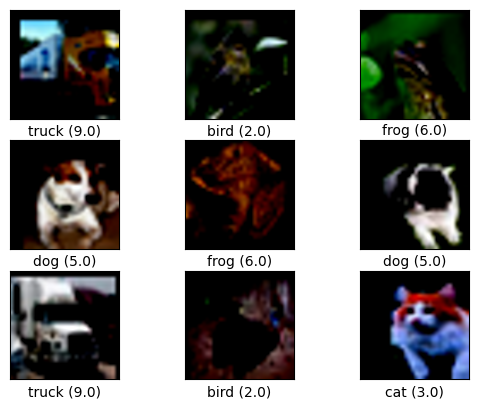

In [ ]:
# implementation

from torchvision.models.alexnet import alexnet, AlexNet_Weights

alex = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to('cuda')

epsilon = [0.001, 0.01, 0.07, 0.3]

if (alex_fgsm_exists):
    # load datasets
    X_alex_fgsm = pickle.load(open('X_alex_fgsm.pk1' , 'rb'))
    y_alex_fgsm = pickle.load(open('y_alex_fgsm.pk1' , 'rb'))
    Xtest_alex_fgsm = pickle.load(open('Xtest_alex_fgsm.pk1' , 'rb'))
    ytest_alex_fgsm = pickle.load(open('ytest_alex_fgsm.pk1' , 'rb'))
else:
    X_alex_fgsm = torch.Tensor()
    y_alex_fgsm = torch.Tensor()
    Xtest_alex_fgsm = torch.Tensor()
    ytest_alex_fgsm = torch.Tensor()

    for e in epsilon:
        # train set
        train_images, train_labels = next(iter(trainloader))
        train_images = train_images.to('cuda')
        x_alex_fgsm = fast_gradient_method(resnet, train_images, e, np.inf, targeted=False)

        X_alex_fgsm = torch.cat((X_alex_fgsm, x_alex_fgsm.cpu()), 0)
        y_alex_fgsm = torch.cat((y_alex_fgsm, train_labels), 0)

        # test set
        test_images, test_labels = next(iter(testloader))
        test_images = test_images.to('cuda')
        xtest_alex_fgsm = fast_gradient_method(resnet, test_images, e, np.inf, targeted=False)

        Xtest_alex_fgsm = torch.cat((Xtest_alex_fgsm, xtest_alex_fgsm.cpu()), 0)
        ytest_alex_fgsm = torch.cat((ytest_alex_fgsm, test_labels), 0)

    # save datasets
    pickle.dump(X_alex_fgsm, open('X_alex_fgsm.pk1' , 'wb'))
    pickle.dump(y_alex_fgsm, open('y_alex_fgsm.pk1' , 'wb'))
    pickle.dump(Xtest_alex_fgsm, open('Xtest_alex_fgsm.pk1' , 'wb'))
    pickle.dump(ytest_alex_fgsm, open('ytest_alex_fgsm.pk1' , 'wb'))

plot_tensor_gpu(X_alex_fgsm.detach(), y_alex_fgsm.detach())

# create a trainloader with adversarial examples
alex_fgsm_train = TensorDataset(X_alex_fgsm, y_alex_fgsm)
alex_fgsm_test = TensorDataset(Xtest_alex_fgsm, ytest_alex_fgsm)

alex_fgsm_trainloader = DataLoader(alex_fgsm_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
alex_fgsm_testloader = DataLoader(alex_fgsm_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


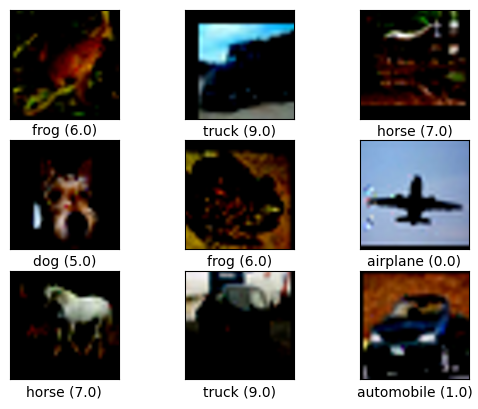

In [ ]:
# Adapted from https://github.com/cleverhans-lab/cleverhans/blob/master/tutorials/torch/cifar10_tutorial.py

if (alex_sl1d_exists):
    # load datasets
    X_alex_sl1d = pickle.load(open('X_alex_sl1d.pk1' , 'rb'))
    y_alex_sl1d = pickle.load(open('y_alex_sl1d.pk1' , 'rb'))
    Xtest_alex_sl1d = pickle.load(open('Xtest_alex_sl1d.pk1' , 'rb'))
    ytest_alex_sl1d = pickle.load(open('ytest_alex_sl1d.pk1' , 'rb'))
else:
    X_alex_sl1d = torch.Tensor()
    y_alex_sl1d = torch.Tensor()
    Xtest_alex_sl1d = torch.Tensor()
    ytest_alex_sl1d = torch.Tensor()

    for e in epsilon:
        # train set
        train_images, train_labels = next(iter(trainloader))
        train_images, train_labels = train_images.to('cuda'), train_labels.to('cuda')
        x_alex_sl1d = sparse_l1_descent(resnet, train_images, y=train_labels, targeted=False)

        X_alex_sl1d = torch.cat((X_alex_sl1d, x_alex_sl1d.cpu()), 0)
        y_alex_sl1d = torch.cat((y_alex_sl1d, train_labels.cpu()), 0)

        # test set
        test_images, test_labels = next(iter(testloader))
        test_images, test_labels = test_images.to('cuda'), test_labels.to('cuda')
        xtest_alex_sl1d = sparse_l1_descent(resnet, test_images, y=test_labels, targeted=False)

        Xtest_alex_sl1d = torch.cat((Xtest_alex_sl1d, xtest_alex_sl1d.cpu()), 0)
        ytest_alex_sl1d = torch.cat((ytest_alex_sl1d, test_labels.cpu()), 0)

    # save datasets
    pickle.dump(X_alex_sl1d, open('X_alex_sl1d.pk1' , 'wb'))
    pickle.dump(y_alex_sl1d, open('y_alex_sl1d.pk1' , 'wb'))
    pickle.dump(Xtest_alex_sl1d, open('Xtest_alex_sl1d.pk1' , 'wb'))
    pickle.dump(ytest_alex_sl1d, open('ytest_alex_sl1d.pk1' , 'wb'))

plot_tensor_gpu(X_alex_sl1d.detach(), y_alex_sl1d.detach())

# create a trainloader with adversarial examples
alex_sl1d_train = TensorDataset(X_alex_sl1d, y_alex_sl1d)
alex_sl1d_test = TensorDataset(Xtest_alex_sl1d, ytest_alex_sl1d)

alex_sl1d_trainloader = DataLoader(alex_sl1d_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
alex_sl1d_testloader = DataLoader(alex_sl1d_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
# use the adversarial dataset to train

ensemble_train = TensorDataset(torch.cat((X_alex_fgsm, X_alex_sl1d), 0), torch.cat((y_alex_fgsm, y_alex_sl1d), 0))

ensemble_trainloader = DataLoader(ensemble_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

if (ensemble_training_model_exists):
  ensemble_training_net = pickle.load(open('ensemble-training-model.pk1' , 'rb'))
else:
  ensemble_training_net = ResNet50(10).to('cuda')

  ensemble_training_criterion = nn.CrossEntropyLoss()
  ensemble_training_optimizer = optim.SGD(ensemble_training_net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
  ensemble_training_scheduler = optim.lr_scheduler.ReduceLROnPlateau(ensemble_training_optimizer, factor = 0.1, patience=5)

  for epoch in range(epochs):
      losses = []
      running_loss = 0
      for i, inp in enumerate(ensemble_trainloader):
          # randomly inject adversarial examples at a rate 1/3 (arbitrarily chosen)
          inputs, labels = inp
          inputs, labels = inputs.to('cuda'), labels.to('cuda')
          ensemble_training_optimizer.zero_grad()

          outputs = ensemble_training_net(inputs)
          loss = ensemble_training_criterion(outputs, labels)
          losses.append(loss.item())

          loss.backward()
          ensemble_training_optimizer.step()

          running_loss += loss.item()

          if i % 100 == 0 and i != 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

      avg_loss = sum(losses)/len(losses)
      ensemble_training_scheduler.step(avg_loss)
      pickle.dump(ensemble_training_net , open('ensemble-training-model.pk1' , 'wb'))


Loss [1, 100](epoch, minibatch):  8.997995488643646
Loss [1, 200](epoch, minibatch):  3.3826216506958007
Loss [2, 100](epoch, minibatch):  2.3623010110855103
Loss [2, 200](epoch, minibatch):  2.2548704862594606
Loss [3, 100](epoch, minibatch):  2.1729918003082274
Loss [3, 200](epoch, minibatch):  2.0934779703617097
Loss [4, 100](epoch, minibatch):  2.055527780056
Loss [4, 200](epoch, minibatch):  1.9865186631679534
Loss [5, 100](epoch, minibatch):  1.9580195844173431
Loss [5, 200](epoch, minibatch):  1.9057238328456878
Loss [6, 100](epoch, minibatch):  1.8854672312736511
Loss [6, 200](epoch, minibatch):  1.8583430385589599
Loss [7, 100](epoch, minibatch):  1.8504526352882384
Loss [7, 200](epoch, minibatch):  1.8257408440113068
Loss [8, 100](epoch, minibatch):  1.8025347888469696
Loss [8, 200](epoch, minibatch):  1.775593377351761
Loss [9, 100](epoch, minibatch):  1.7655860817432403
Loss [9, 200](epoch, minibatch):  1.7145738220214843
Loss [10, 100](epoch, minibatch):  1.720102038383484

# Testing all models against original and adversarial examples

In [ ]:
# testing
score(resnet, testloader)
score(ensemble_training_net, testloader)

Accuracy on 10,000 images:  78.91 %
Accuracy on 10,000 images:  25.180000000000003 %
Accuracy on 10,000 images:  75.16000000000001 %


In [ ]:
#
score(resnet, fgsm_testloader)
score(ensemble_training_net, fgsm_testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy on 10,000 images:  53.90625 %
Accuracy on 10,000 images:  11.1328125 %
Accuracy on 10,000 images:  58.59375 %


In [ ]:
score(resnet, cw_testloader)
score(ensemble_training_net, cw_testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy on 10,000 images:  38.671875 %
Accuracy on 10,000 images:  11.1328125 %
Accuracy on 10,000 images:  50.78125 %


In [ ]:
score(resnet, sl1d_testloader)
score(ensemble_training_net, sl1d_testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy on 10,000 images:  25.0 %
Accuracy on 10,000 images:  9.9609375 %
Accuracy on 10,000 images:  67.3828125 %
